# Урок 5. Случайный лес

1. Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50, 100, 200 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.
2. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [139]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np
import pandas as pd

In [65]:
# сгенерируем данные, представляющие собой 500 объектов с 5-ю признаками
classification_data, classification_labels = datasets.make_classification(n_samples=1000,
                                                                          n_features = 2, 
                                                                          n_informative = 2, 
                                                                          n_classes = 2, 
                                                                          n_redundant=0, 
                                                                          n_clusters_per_class=1, 
                                                                          flip_y=0.25,
                                                                          random_state=45)

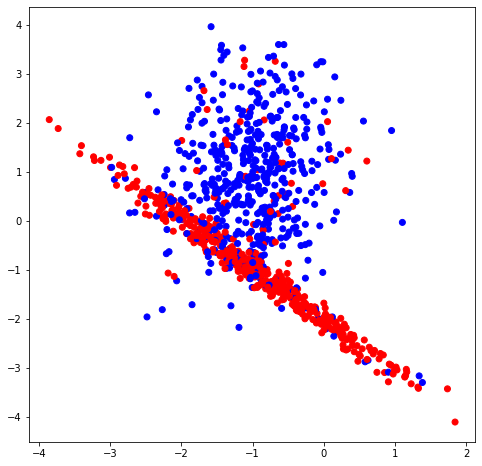

In [66]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

#### добавил в возврат функции листы данных/классов, на которых не обучалось конкретное дерево:

In [153]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []

    for i in range(N):
        used_indexes = set()
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        b_test_data = [] # данные на которых НЕ будет учиться дерево
        b_test_labels = [] # соответствующие тестовым данным классы
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples - 1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            used_indexes.add(sample_index)

        for idx in range(n_samples): # цикл проходит от 0 до кол-ва данных
            if idx not in used_indexes: # проверяет, входит ли индекс в список уже использованных
                b_test_data.append(data[idx])
                b_test_labels.append(labels[idx])
        b_test_data = np.array(b_test_data) # конвертируем полученные тест списки в np.array для будущего удобства
        b_test_labels = np.array(b_test_labels)

        bootstrap.append((b_data, b_test_data, b_labels, b_test_labels))

    return bootstrap

In [5]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [6]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [7]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [8]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [9]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [10]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [11]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [12]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

#### сделал accuracy_log, в котором хронятся результаты замеров accuracy для каждого из деревьев

In [133]:
def random_forest(data, labels, n_trees):
    forest = []
    accuracy_log = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_test_data, b_labels, b_test_labels in bootstrap:
        tree = build_tree(b_data, b_labels)
        forest.append(tree)
        
        train_acc = accuracy_metric(b_labels, predict(b_data, tree))
        test_acc = accuracy_metric(b_test_labels, predict(b_test_data, tree))
        accuracy_log.append([train_acc, test_acc])
    accuracy_log = np.array(accuracy_log)
        
    return forest, accuracy_log

In [14]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [15]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [16]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [67]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [20]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

## Задание 1
- Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками,  
- Обучить случайный лес из 1, 3, 10 и 50, 100, 200 деревьев
- Визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока)
- Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

Обернул построение графиков в функцию, для удобства

In [83]:
def visualize_hyperplane(forest, train_data, test_data):
    
    train_answers = tree_vote(forest, train_data)
    test_answers = tree_vote(forest, test_data)
    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy = accuracy_metric(test_labels, test_answers)
    
    def get_meshgrid(data, step=.05, border=1.2):
        x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
        y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
        return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

Строим 6 лесов

In [76]:
my_forest1, accuracy_log1 = random_forest(train_data, train_labels, 1)
my_forest3, accuracy_log1 = random_forest(train_data, train_labels, 3)
my_forest10, accuracy_log1 = random_forest(train_data, train_labels, 10)
my_forest50, accuracy_log1 = random_forest(train_data, train_labels, 50)
my_forest100, accuracy_log1 = random_forest(train_data, train_labels, 100)
my_forest200, accuracy_log1 = random_forest(train_data, train_labels, 200)

#### Случайный лес из 1 дерева

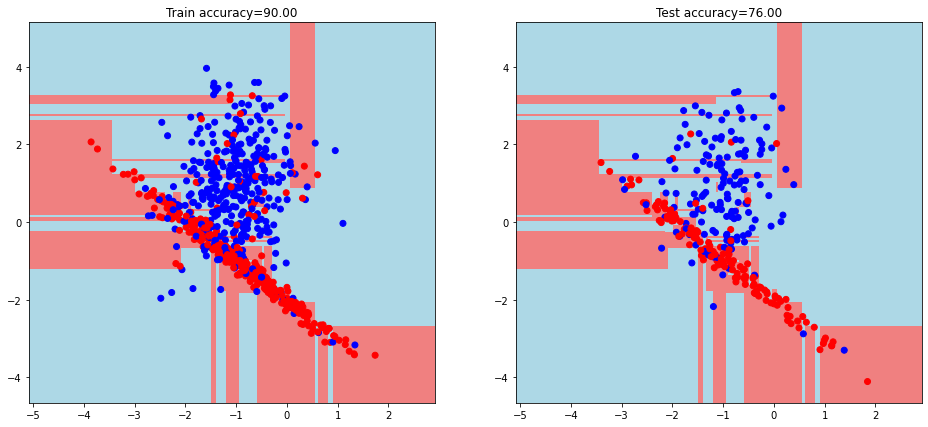

In [84]:
visualize_hyperplane(my_forest1, train_data, test_data)

#### Случайный лес из 3 деревьев

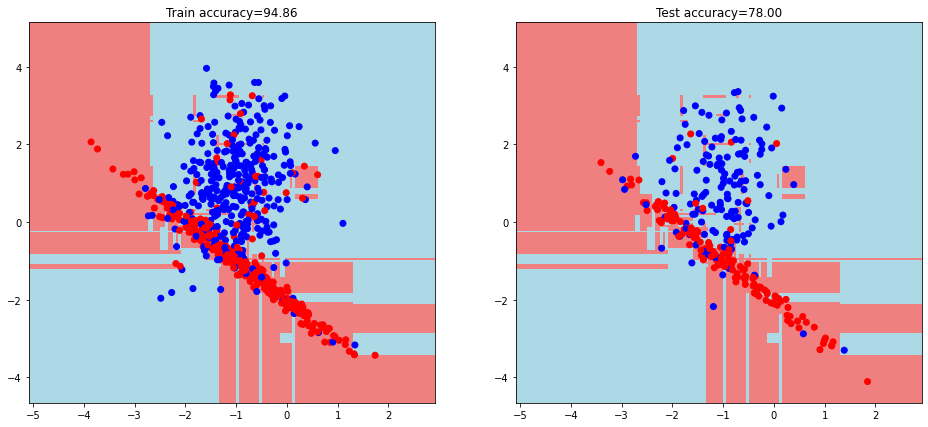

In [85]:
visualize_hyperplane(my_forest3, train_data, test_data)

#### Случайный лес из 10 деревьев

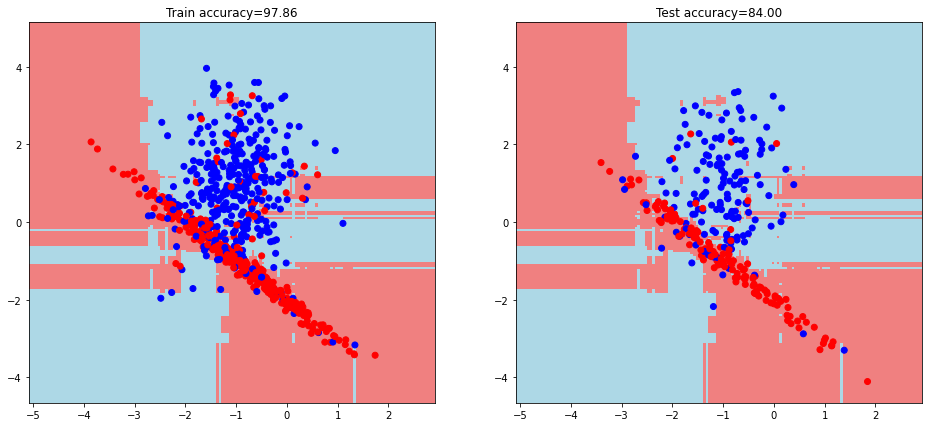

In [86]:
visualize_hyperplane(my_forest10, train_data, test_data)

#### Случайный лес из 50 деревьев

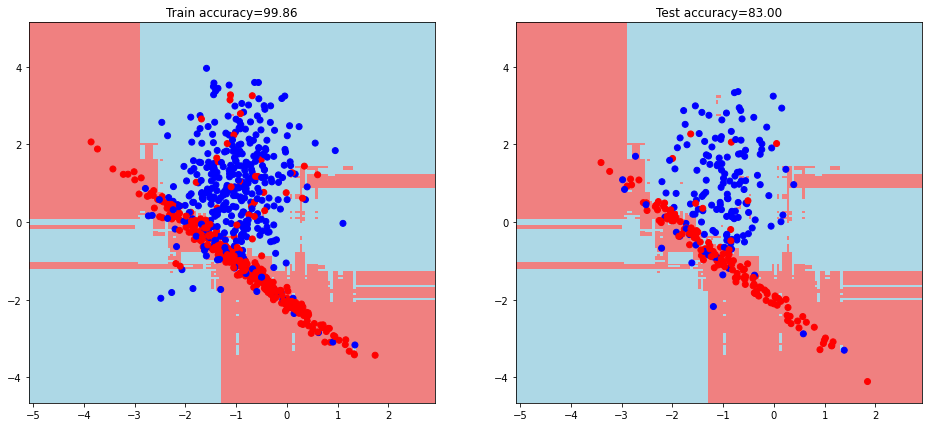

In [87]:
visualize_hyperplane(my_forest50, train_data, test_data)

#### Случайный лес из 100 деревьев

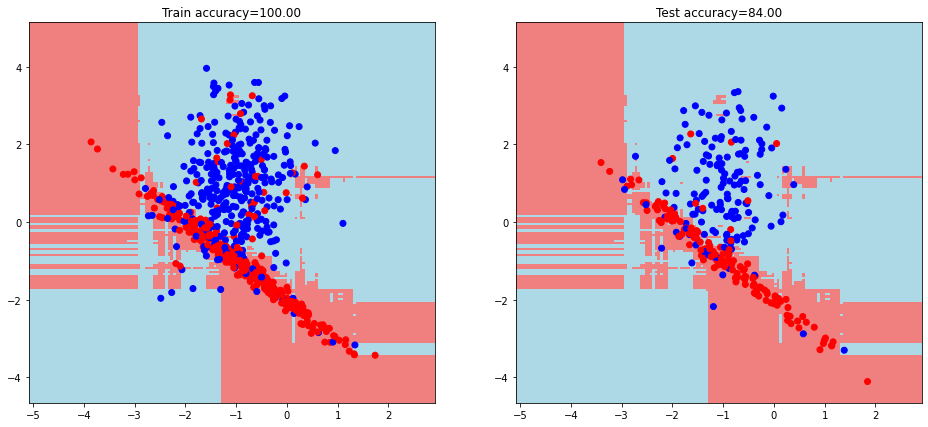

In [88]:
visualize_hyperplane(my_forest100, train_data, test_data)

#### Случайный лес из 200 деревьев

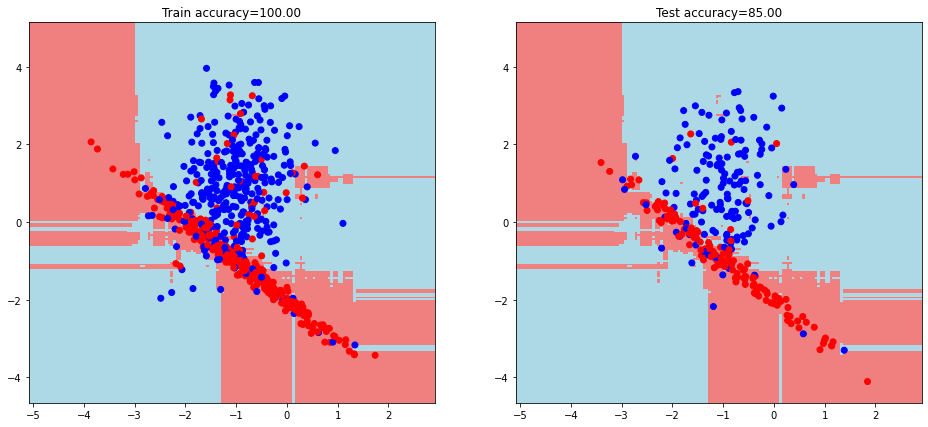

In [123]:
visualize_hyperplane(my_forest200, train_data, test_data)

С увеличением кол-ва деревьем в лесу у нас увеличивается accuracy не только на train выборке, но и на test  
  
Безусловно, каждое дерево внутри леса само по себе переобученное, так как мы видим кучу полосочек, которые "разрывают" гиперплоскость  
  
Однако с увеличением кол-ва деревьев, bagging объединяет их результаты, чем компенсирует переобученность каждого отдельного дерева  
  
Из-за этого у нас растет accuracy не только на train, но и на test выборке. Такая себе природная регуляризация :)

## Задание 2. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

Внеся правки в <code>get_bootstrap()</code> и <code>random_forest()</code> я реализовал Out-of-Bag проверку  
  
Сейчас <code>get_bootstrap()</code> возвращает нумпай эррей, в котором есть не только b_data, b_labels, а и b_test_data + b_test_labels 
*(данные, которые не попали в бутстрап выборку, и на которых не учится дерево)*
  
<code>random_forest()</code> теперь возвращает <code>accuracy_log</code>, в котором содержит списки списков с метриками accuracy для каждого дерева в лесу 
*(метрики посчитаны и для обучающей выборки дерева и для тестовой (которой не было в бутстрап))*
  
Теперь не имеет смысла кормить случайному лесу разбитые на train/test данные  
  
Поэтому передаем ему полные <code>classification_data/classification_labels</code>

In [154]:
my_forest, accuracy_log = random_forest(classification_data, classification_labels, 50)

In [157]:
def vis_hyperp_ofb(forest, accuracy_log, data, labels):
    
    acc = pd.DataFrame(accuracy_log)
    train_mean_acc = acc[0].mean() # средняя аккуратность всех деревьев на трейне
    test_mean_acc = acc[1].mean() # средняя аккуратность всех деревьев на тесте
    print(f'Mean train accuracy of each tree={train_mean_acc:.2f} | Mean test accuracy of each tree={test_mean_acc:.2f}')
    
    forest_answers = tree_vote(forest, data)
    forest_accuracy = accuracy_metric(labels, forest_answers) # аккуратность всего леса на данных
    
    def get_meshgrid(data, step=.05, border=1.2):
        x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
        y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
        return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    
    xx, yy = get_meshgrid(data)
    mesh_predictions = np.array(tree_vote(forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    
    plt.figure(figsize = (10, 8))

    # график обучающей выборки
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
    plt.scatter(data[:, 0], data[:, 1], c = classification_labels, cmap = colors)
    plt.title(f'Forest accuracy = {forest_accuracy:.2f}')
    
    plt.show()

Mean train accuracy of each tree=100.00 | Mean test accuracy of each tree=75.11


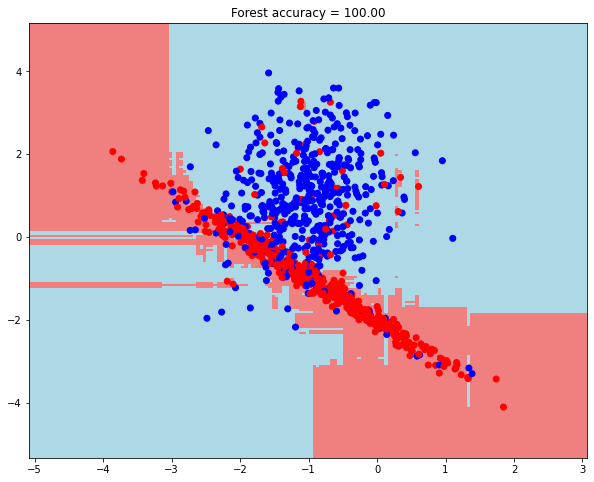

In [158]:
vis_hyperp_ofb(my_forest, accuracy_log, classification_data, classification_labels)

Как мы можем увидеть, хоть аккуратность отдельно взятых деревьев в среднем составляла +-75%, лес деревьев с out-of-bag проверкой состоящий из 50 деревьев выдал аккуратность 100%  
  
Таких результатов мы не достигали даже строя лес из 200 деревьев  
  
Видно, что модель немного переобучена, но в общих чертах она выглядит почти как модель случайного леса из 200 деревьев без out-of-bag
  
Все логично, все так и должно быть. Ставлю случайному лесу с out-of-bag проверкой лайк, за то что теперь данные не нужно делить на train/test :)